<a href="https://colab.research.google.com/github/CharlesGignac-CRDIG/Partage/blob/main/Formation_geemap_de_L'AQT_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INITIALISATION DES OUTILS #

In [ ]:
import ee
import geemap
import geopandas as gpd
import pandas as pd
!pip install pycrs
import pycrs
!pip install sweetviz
!pip install autoviz
import sweetviz as sv
from autoviz.AutoViz_Class import AutoViz_Class
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

In [ ]:
geemap.ee_initialize()



---

#PARTIE 1 : FONDEMENTS ET BASES DE GEEMAP#

# COMMENT CRÉER DES ENTITÉS VECTORIELLES ??? #


**CRÉATION D'UNE ENTITÉ DE TYPE GEOMETRY - Point aux coordonnées du pavillon Ringuet**

In [ ]:
# Les coordonnées géographiques du pavillon Ringuet de l'Université du Québec à Trois-Rivières (UQTR) sont approximativement les suivantes - Latitude : 46.34764266714028 - Longitude : -72.57617087988571
point = ee.Geometry.Point([-72.57617087988571, 46.34764266714028])

In [ ]:
# Pour voir les métadonnées simples de la géométrie chargée, on peut l'appeler par son nom de variable.
point

In [ ]:
# Créons une zone tampon circulaire de 2km autour du point. Nous l'utiliserons comme région d'intérêt (ROI).
# D'abord, nous devons convertir dans un système de coordonnées planaires. Nous utiliserons le Conique Conforme Lambert - CCL (EPSG:102002)
# Source : https://mrnf.gouv.qc.ca/wp-content/uploads/CO_codes_epsg_quebec.pdf
point_CCL = point.transform("EPSG:102002")
ROI = point.buffer(2000)

**CRÉATION D'UNE ENTITÉ DE TYPE FEATURE - Point aux coordonnées de L'UQTR avec attributs**

> Bloc en retrait



In [ ]:
# Pour que cette étape se complète sans erreur, il faut que la géométrie "point" soit préalablement définie.
pointFeature = ee.Feature(point, {'Numérique':42, 'Textuel':'UQTR'})

In [ ]:
# Pour voir les métadonnées simples de l'entité chargée, on peut l'appeler par son nom de variable.
pointFeature

▶ *On peut alors interroger les attributs de la donnée "Feature" grâce à l'opérateur .get('attribut')*

In [ ]:
textuel = pointFeature.get('Textuel')
textuel

**CRÉATION D'UNE ENTITÉ DE TYPE FEATURECOLLECTION - Les empreintes des pavillons de L'UQTR utilisés lors du congrès de L'AQT 2023**

▶ On peut créer une FeatureCollection à partir de features *existants*

In [ ]:
Liste =  [ee.Feature(ee.Geometry.Point(-72.553844,46.362309), {'Numérique':42, 'Textuel':'Trois-Rivières'}), ee.Feature(ee.Geometry.Point(-71.208000,46.813900), {'Numérique':43, 'Textuel':'Québec'})]
featureCollection =  ee.FeatureCollection(Liste)

In [ ]:
featureCollection

▶ Mais, tirons profit de la capacité de numérisation manuelle de geemap pour délimiter les pavillons Ringuet, Léon-Provencher et La Chasse-Galerie.

In [ ]:
# D'abord, il faut créer un interface cartographique.
Map = geemap.Map()

In [ ]:
# Ensuite, extrayons la latitude et la longitude de l'entité pointFeature.
lon, lat = point.coordinates().getInfo()

In [ ]:
# APPROCHE #1 : Centrons la carte sur le Pavillon Ringuet de l'UQTR grâce à la latitude et la longitude extraites et fixons le niveau de zoom à 8.
Map.setCenter(lat,lon,zoom=18)

In [ ]:
# APPROCHE #2 : Centrons la carte sur le Pavillon Ringuet de l'UQTR grâce à la variable pointFeature et fixons le niveau de zoom à 8.
Map.centerObject(pointFeature,zoom=18)

▶ Créons une FeatureCollection en mode graphique

In [ ]:
Map

In [ ]:
# Numérisez les pavillons Provancher, Ringuet et La Chasse-Galerie.
# On récupère les entités numérisées sur la carte pour les stocker vers une liste.
roi_list = Map.draw_features
print(roi_list)
print(type(roi_list))

In [ ]:
# On convertit la liste vers une FeatureCollection
batiments = ee.FeatureCollection(roi_list)

In [ ]:
# Remarquez que les entités de la collection n'ont pas d'attribut permettant de les identifier.
batiments

In [ ]:
# La manière la plus simple d'assigner une nouvelle colonne est de passer la FeatureCollection vers un format geodataframe (geopandas).
gdf = geemap.ee_to_geopandas(batiments)
noms = ['Léon-Provancher', 'Ringuet', 'La Chasse-Galerie']
gdf['Nom'] = noms
gdf

In [ ]:
# Rapportons ensuite le geodataframe vers geemap. Il faut utiliser un set_crs afin de spécifier le système de coordonnées utilisé, ici le WGS84 et son code EPSG : 4326.
pavillons = geemap.geopandas_to_ee(gdf.set_crs(4326))

▶ Ajoutons la FeatureCollection créée sur la carte

In [ ]:
# Il y a une différence entre le dessin de géométries sur la carte et l'affichage de données.
# Retirons les géométries dessinées (manuellement) et ajoutons la donnée sur les bâtiments à la carte.
Map

In [ ]:
Map.addLayer(pavillons,{},'Pavillons UQTR-AQT 2023')

In [ ]:
# Ajoutons également la ROI de 2km.
Map.addLayer(ROI,{},"ZONE D'INTÉRÊT")



---

# COMMENT AJOUTER UNE DONNÉE VECTORIELLE EXTERNE ?? #

▶ Alternative 1 : À partir d'une URL

In [ ]:
# Nous ferons le test avec les données du réseau routier de la Ville de Trois-Rivières.
URL="https://www.donneesquebec.ca/recherche/dataset/17e9938c-c744-4171-b7bc-53abd7a6d8bc/resource/2365b55b-2d1b-4a53-979e-34b29c701b1b/download/reseau-routier-v3r.json"
gdf = gpd.read_file(URL)
routes = geemap.geopandas_to_ee(gdf).filterBounds(ROI)

▶ Alternative 2 : À partir d'un fichier local

In [ ]:
gdf = gpd.read_file("/content/reseau-routier-v3r.json")
routes = geemap.geopandas_to_ee(gdf).filterBounds(ROI)

▶ On peut ensuite ajouter les routes à la carte et en profiter pour ajouter un style particulier

In [ ]:
# On débute par définir le style désiré dans une variable.
visualisation_routes = {'color' : 'red', 'colorOpacity' : 0.5, 'width' : 2}

In [ ]:
Map.addLayer(routes, visualisation_routes, name='Réseau routier')

In [ ]:
Map

⏸ **AVEZ-VOUS DES QUESTIONS POUR LES DONNÉES VECTORIELLES ?**



---

# COMMENT CHARGER DES COLLECTIONS DE DONNÉES ??? #

**CHARGEMENT D'UNE ENTITÉ DE TYPE FEATURECOLLECTION - Les relevés LiDAR du capteur spatioporté GEDI**

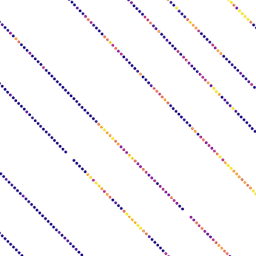

In [ ]:
# Détection du jeu de données à utiliser à partir de l'index.
GEDI_set = ee.FeatureCollection("LARSE/GEDI/GEDI02_A_002_INDEX").filterBounds(ROI)
triGEDI = GEDI_set.sort("system:time_start", False).first()
GEDI_data = ee.FeatureCollection(triGEDI.get('table_id').getInfo()).filterBounds(ROI)
Map.addLayer(GEDI_data,{},'GEDI_data')

In [ ]:
Map

**CHARGEMENT D'UNE ENTITÉ DE TYPE IMAGE - SRTM Plus, Données d'élévation à 30m de résolution**

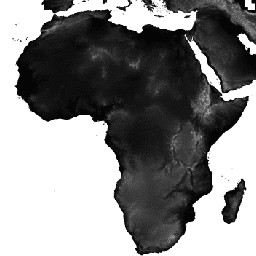

In [ ]:
# Référence : https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003
image = ee.Image("USGS/SRTMGL1_003").clip(ROI)

In [ ]:
# Pour voir les métadonnées simples de la couche image chargée, on peut l'appeler par son nom de variable.
image

In [ ]:
# Pour voir les métadonnées sous format JSON de la couche image chargée, on ajoute l'instruction getInfo() au nom de variable.
image.getInfo()

In [ ]:
# Ajoutons cette couche Image à la carte.
# La palette de couleurs est définie à partir de valeurs hexadécimale (Voir : https://www.color-hex.com/)
visualisation_SRTM30 = {'min':0, 'max':300, 'palette': ['#440154', '#414487', '#2A788E', '#22A784', '#7AD151', '#FDE724']} # Palette similaire à Viridis.
Map.addLayer(image, visualisation_SRTM30, 'Élévation')

In [ ]:
#Affichons la carte et ajustons dynamiquement la gamme de valeurs pour qu'elle soit entre 0 et 50m.
Map

**CHARGEMENT D'UNE ENTITÉ DE TYPE IMAGECOLLECTION - Réflectances de surface Sentinel-2 à 10 m de résolution spatiale**

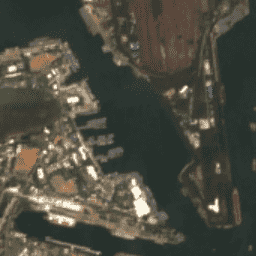

In [ ]:
# Référence : https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

In [ ]:
# Pour voir les métadonnées simples de la collection chargée, on peut l'appeler par son nom de variable, mais on doit circonscrire la collection à un nombre limité d'éléments grâce à l'opérateur "limit(n)"
collection.limit(1)

▶ Nous avons une collection d'images, donc plusieurs couches. On ne peut donc pas simplement afficher cette collection, il faut d'abord la filtrer.

Voici des exemples :

*   *Valeur minimale en septembre 2023.*
*   *Image la plus récente sans nuages.*

In [ ]:
# VALEUR MINIMALE EN SEPTEMBRE 2023.
filtre = collection.filterDate("2023-09-01", "2023-09-30").filterBounds(ROI)
minimal = filtre.min().clip(ROI)

In [ ]:
# IMAGE LA PLUS RÉCENTE DE 2023 SANS NUAGES (<=10% de nuages).
filtre = collection.filterDate("2023-01-01", "2023-10-22").filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)).filterBounds(ROI)
tri = filtre.sort("system:time_start", False)
recente = tri.first().clip(ROI)

In [ ]:
# Ajoutons la couche minimal avec un composé coloré spécifique : NIR-RVB (B8, B4, B3)
Map.addLayer(minimal, {'bands': ['B8', 'B4', 'B3'], 'min': 0, 'max': 3000}, 'Mediane Sentinel-2')

# Ajoutons la couche récente sans nuages avec un composé coloré spécifique : Couleurs naturelles (B4, B3, B2)
Map.addLayer(recente, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Couleurs réelles sans nuages Sentinel-2')

In [ ]:
Map



---

##FIN DE LA PARTIE 1 - PAUSE DE 15 MINUTES##



---



#PARTIE 2: TRAITEMENTS, CONVERSIONS ET CALCULS#

##Scénario de traitement##

Dans cette section, nous explorerons les capacités de traitement, de conversion et de calcul matriciel de GEE via geemap.

Nos analyses viseront à répondre aux objectifs suivants :


*   Estimer le NDVImaximal mensuel de chaque parcelle agricole de maïs (grain et fourrager) se trouvant dans la base de données des parcelles et productions agricoles déclarées pour l'année 2022 dans la MRC de Bécancour.
*   Estimer la rétrodiffusion radar maximale mensuelle de chaque parcelle agricole de maïs (grain et fourrager) se trouvant dans la base de données des parcelles et productions agricoles déclarées pour l'année 2022 dans la MRC de Bécancour.
*   Modéliser statistiquement le lien unissant le NDVI maximal mensuel et la rétrodiffusion radar maximale mensuelle des parcelles agricoles de maïs (grain et fourrager) dans la MRC de Bécancour.





In [250]:
# Redémarrons de zéro avec une carte sans données.
Map = None
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [251]:
# Télécharger les données de la BDPPAD pour l'année 2023.
import requests
import zipfile
import io

# Requête pour obtenir le jeu de données allégé.
url = "http://matrivex.com/wp-content/uploads/2023/10/BDPPAD_2023_AQT2023_MAF.zip"

# Requête pour obtenir le jeu de données en entier (très lourd).
# url = 'https://www.fadq.qc.ca/fileadmin/geo4tb/BDPPAD/BDPPAD_V03_2023.zip'

response = requests.get(url)
if response.status_code == 200:
    with io.BytesIO(response.content) as buffer:
        with zipfile.ZipFile(buffer, 'r') as zip_ref:
            zip_ref.extractall('/content/BDPPAD/')
else:
    print("Error: Unable to download the file")

In [252]:
# Télécharger un polygone de la MRC de Bécancour.
# Source = https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2
GAUL = ee.FeatureCollection("FAO/GAUL/2015/level2")
MRC = GAUL.filter(ee.Filter.eq('ADM2_NAME', 'Bécancour'));
Map.addLayer(MRC,{},'Limite MRC')

In [253]:
# Chargeons les parcelles de la BDPPAD 2023 dans une featureCollection.
# C'est un très large jeu de données. Son transfert vers le serveur et sa lecture peuvent prendre jusqu'à 10 minutes.
# C'est donc une version allégée qui vous a été fournie, sa lecture prends environ 5 secondes.
parcelles = geemap.geojson_to_ee("/content/BDPPAD/BDPPAD_2023_AQT2023_MAF.geojson").filterBounds(MRC)

In [254]:
Map.addLayer(parcelles,{},'Parcelles')

## Objectif 1 : Obtenir le NDVI Sentinel-2 maximal mensuel pour chaque parcelle ##

In [340]:
# Fonction qui sert à calculer le NDVI en utilisant l'opérateur "normalizedDifference" sur chaque image.
# Les bandes 8 et 4 de Sentinel-2 sont respectivement le PIR et le rouge.
def calcul_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Charger la collection pour l'année 2022.
start_date = '2022-01-01'
end_date = '2022-12-31'

sentinel2 = ee.ImageCollection('COPERNICUS/S2').filterBounds(MRC).filterDate(start_date, end_date).map(calcul_ndvi)

# Création d'une liste des mois.
mois = ee.List.sequence(1, 12)

# Fonction qui calcule le maximum mensuel.
def maximum_mensuel(mois):
    return sentinel2.filter(ee.Filter.calendarRange(mois, mois, 'month')).max().set('month', mois)

NDVI_Mensuel = ee.ImageCollection.fromImages(mois.map(maximum_mensuel)).select('NDVI')

In [341]:
# Explorons la structure de NDVI_Mensuel afin de bien saisir ce qui est généré par geemap.
NDVI_Mensuel

In [342]:
def ndvi_max_par_parcelle(image):
  month = image.get('month')
  ndvi_stats = image.reduceRegions(collection=parcelles, reducer=ee.Reducer.max(), scale=10)
  return ndvi_stats.map(lambda feature: feature.set({'month': month}))

In [343]:
ndvi_stats = NDVI_Mensuel.map(ndvi_max_par_parcelle).flatten()

In [344]:
gdf_ndvi = geemap.ee_to_geopandas(ndvi_stats)

In [345]:
nombre_de_parcelles = gdf['IDPAR'].nunique()
print("Nombre de parcelles :", nombre_de_parcelles)

Nombre de parcelles : 314


In [346]:
gdf_tri = gdf.sort_values(by=['IDPAR', 'month'], ascending=[True, True])
gdf_tri.to_file("/content/BDPPAD/NDVI_MAXIMAL_MENSUEL_PAR_PARCELLE_2023.geojson")

## Objectif 2 : Obtenir la rétrodiffusion médiane mensuelle pour chaque parcelle ##

In [347]:
# Charger la collection pour l'année 2022.
start_date = '2022-01-01'
end_date = '2022-12-31'

sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(MRC).filterDate(start_date, end_date).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))

sentinel1_VV = sentinel1.select('VV')
sentinel1_VH = sentinel1.select('VH')

# Création d'une liste des mois.
mois = ee.List.sequence(1, 12)

# Fonction qui calcule le maximum mensuel.
def maximum_mensuel_VV(mois):
    return sentinel1_VV.filter(ee.Filter.calendarRange(mois, mois, 'month')).max().set('month', mois)

def maximum_mensuel_VH(mois):
    return sentinel1_VH.filter(ee.Filter.calendarRange(mois, mois, 'month')).max().set('month', mois)

VV_Mensuel = ee.ImageCollection.fromImages(mois.map(maximum_mensuel_VV))
VH_Mensuel = ee.ImageCollection.fromImages(mois.map(maximum_mensuel_VH))

In [348]:
# Explorons la structure de VV_Mensuel afin de bien saisir ce qui est généré par geemap.
VV_Mensuel

In [349]:
def retrodiffusion_max_par_parcelle(image):
  month = image.get('month')
  ndvi_stats = image.reduceRegions(collection=parcelles, reducer=ee.Reducer.max(), scale=10)
  return ndvi_stats.map(lambda feature: feature.set({'month': month}))

In [350]:
VV_stats = VV_Mensuel.map(retrodiffusion_max_par_parcelle).flatten()
VH_stats = VH_Mensuel.map(retrodiffusion_max_par_parcelle).flatten()

In [351]:
gdf_VV = geemap.ee_to_geopandas(VV_stats)
gdf_VH = geemap.ee_to_geopandas(VH_stats)

In [352]:
gdf_tri_VV = gdf_VV.sort_values(by=['IDPAR', 'month'], ascending=[True, True])
gdf_tri_VV.to_file("/content/BDPPAD/VV_MAXIMAL_MENSUEL_PAR_PARCELLE_2023.geojson")

gdf_tri_VH = gdf_VH.sort_values(by=['IDPAR', 'month'], ascending=[True, True])
gdf_tri_VH.to_file("/content/BDPPAD/VH_MAXIMAL_MENSUEL_PAR_PARCELLE_2023.geojson")

## Objectif 3 : Explorer le lien entre les rétrodiffusions maximales mensuelles et le NDVI maximal mensuel pour les parcelles agricoles de maïs fourrager dans la MRC de Bécancour en 2023 ##

In [377]:
df = pd.DataFrame({'VV_MAX': gdf_tri_VV['max'],'VH_MAX': gdf_tri_VH['max'],'NDVI_MAX': gdf_ndvi['max'],'MOIS':gdf_ndvi['month']})
df_COMPLET = df.drop(columns=['MOIS'])
df_ETE = df[(df['MOIS']>=6) & (df['MOIS']<=11)].drop(columns=['MOIS'])

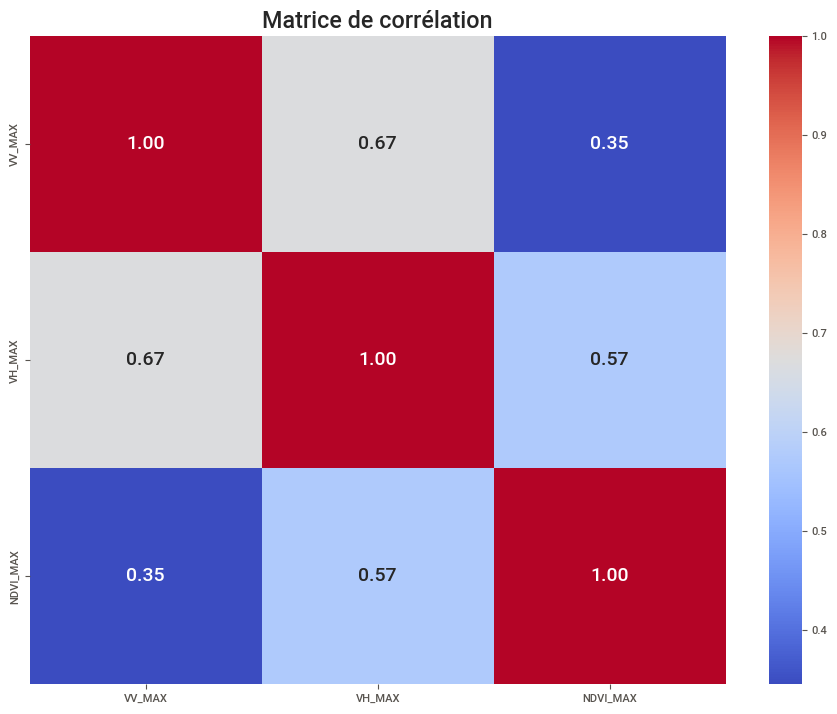

In [378]:
# Calculate the correlation matrix
correlation_matrix = df_COMPLET.corr()

# Tracer la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

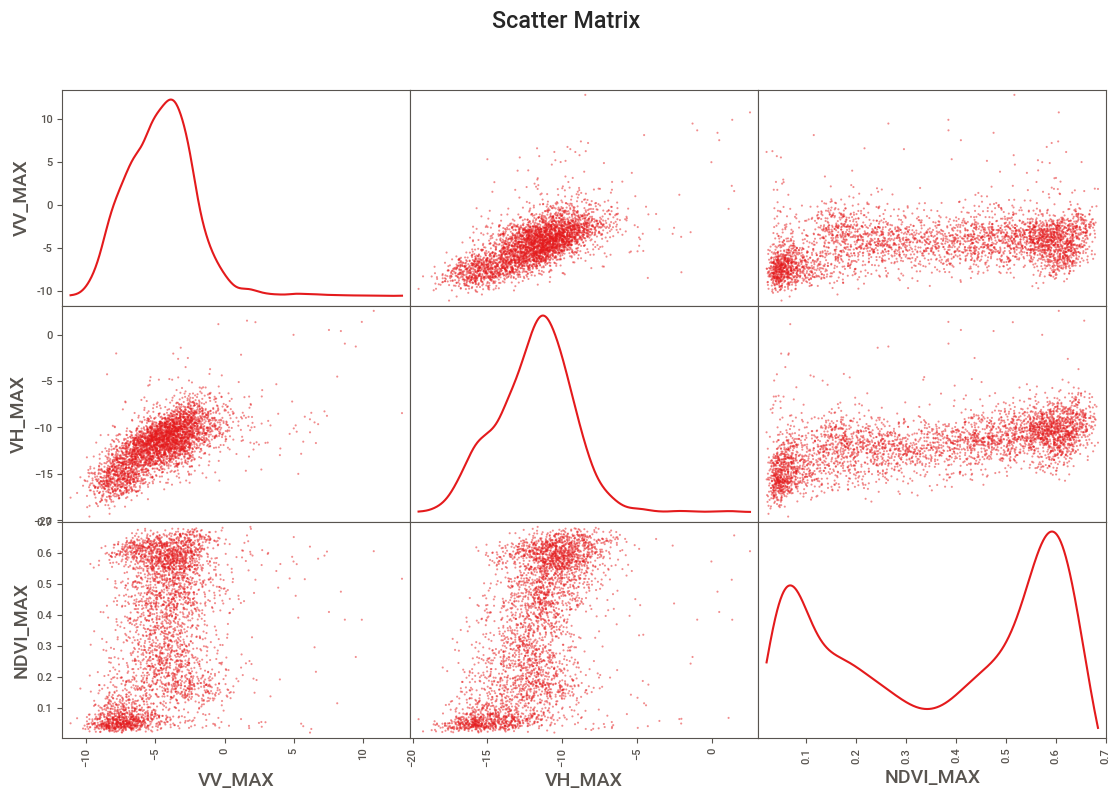

In [379]:
scatter_matrix = pd.plotting.scatter_matrix(df_COMPLET, figsize=(12, 8), diagonal='kde')
plt.suptitle("Scatter Matrix")
plt.show()

In [380]:
# Generate a report
report = sv.analyze(df_COMPLET)

# Show the report
report.show_html('report_SWEETVIZ.html')  # This will save the report as an HTML file

                                             |          | [  0%]   00:00 -> (? left)

Report report_SWEETVIZ.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Shape of your Data Set loaded: (3768, 4)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    4 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
To fix data quality issues automatically, import FixDQ from autoviz...


,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
VV_MAX,float64,0.000000,NA,-11.122669,12.824160,has 51 outliers greater than upper bound (1.82) or lower than lower bound(-11.26). Cap them or remove them.
VH_MAX,float64,0.000000,NA,-19.595059,2.544773,has 39 outliers greater than upper bound (-5.29) or lower than lower bound(-18.38). Cap them or remove them.
NDVI_MAX,float64,0.000000,NA,0.019944,0.684530,No issue
MOIS,int64,0.000000,0,1.000000,12.000000,No issue


Number of All Scatter Plots = 6


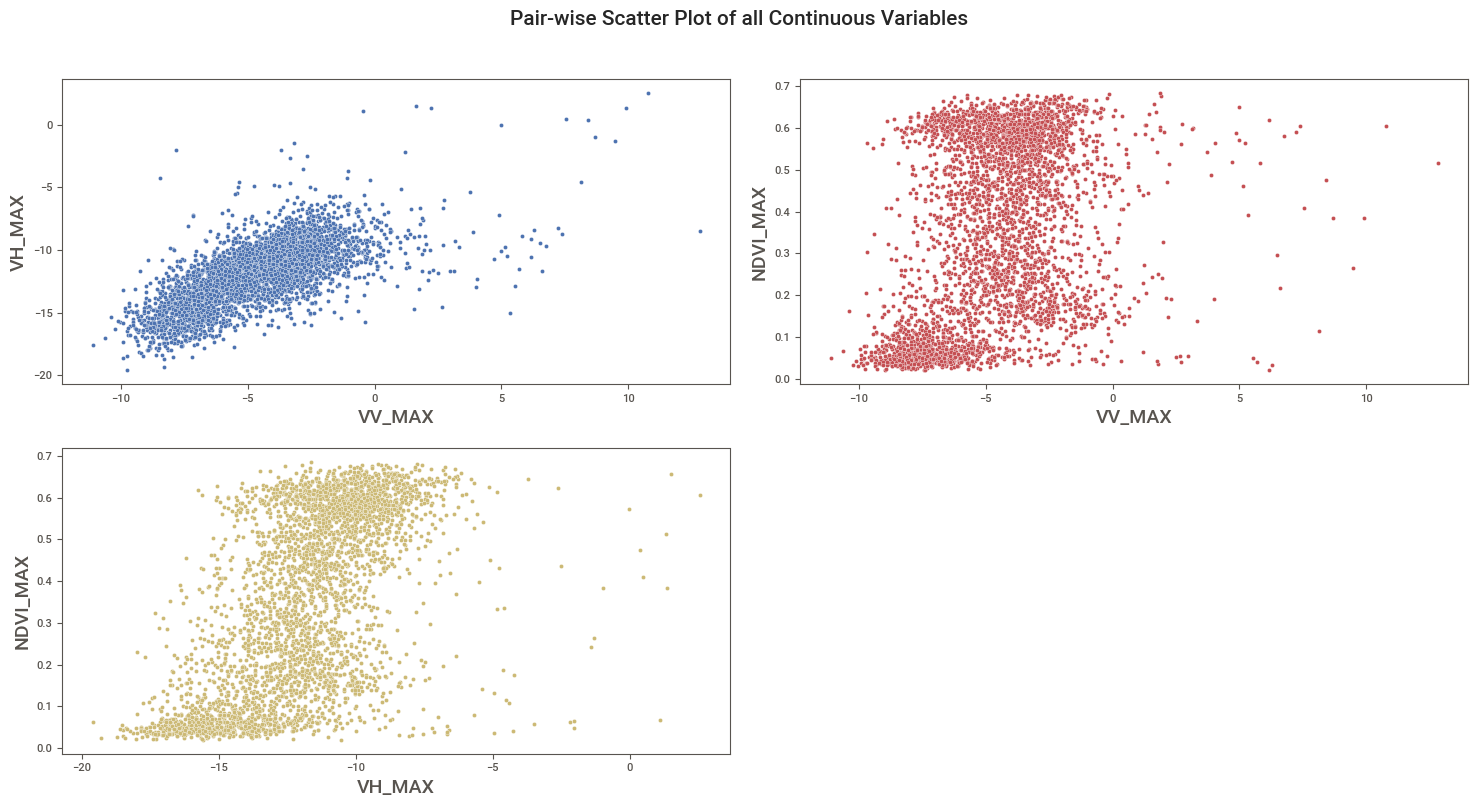

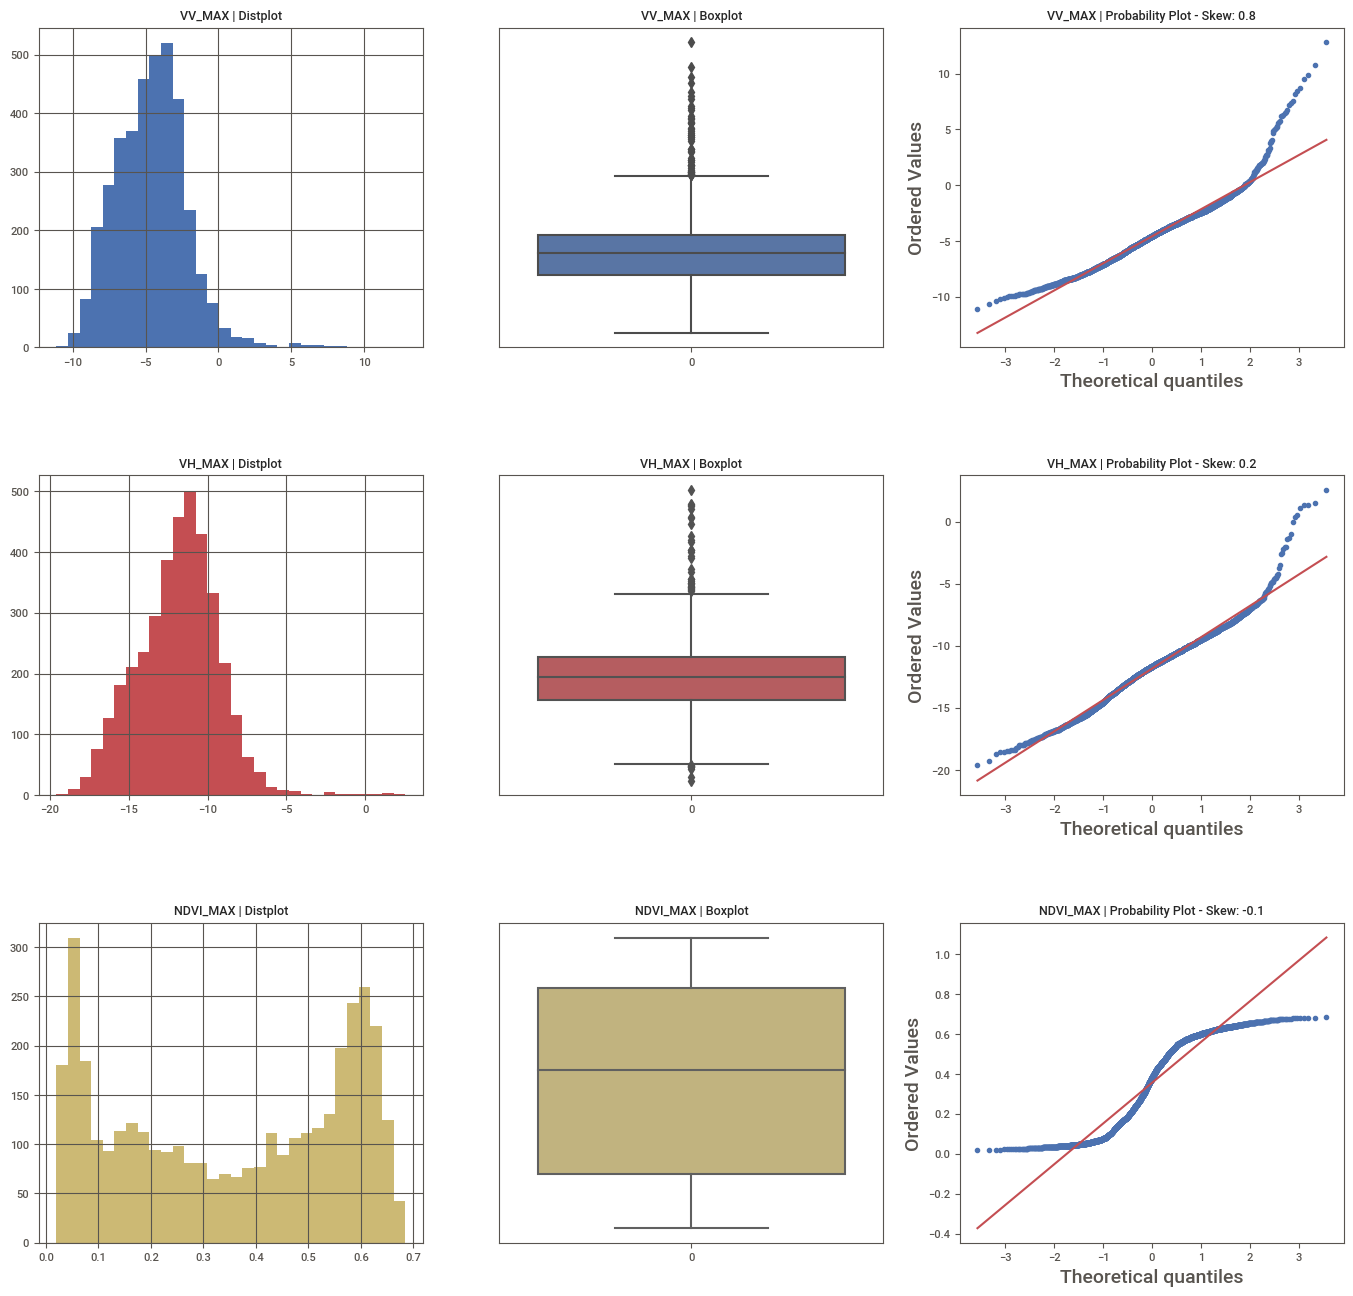

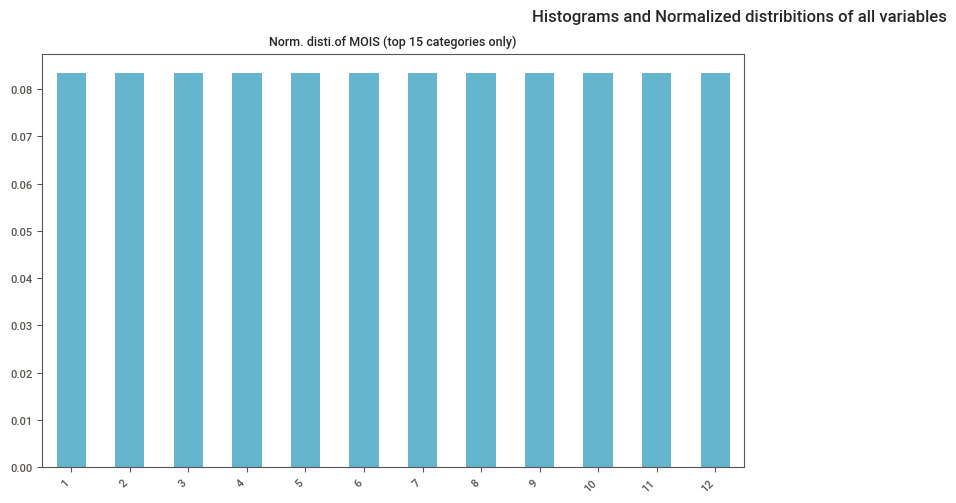

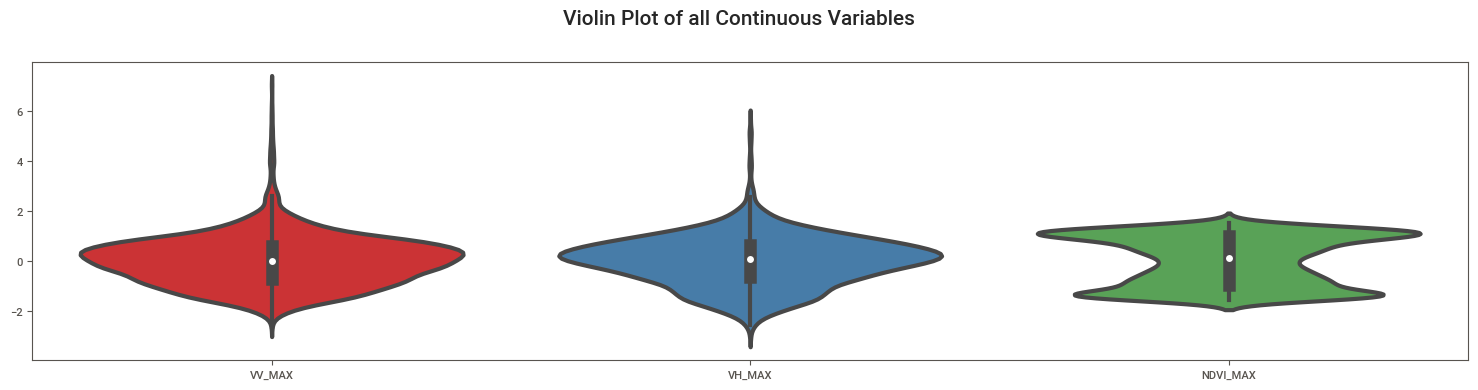

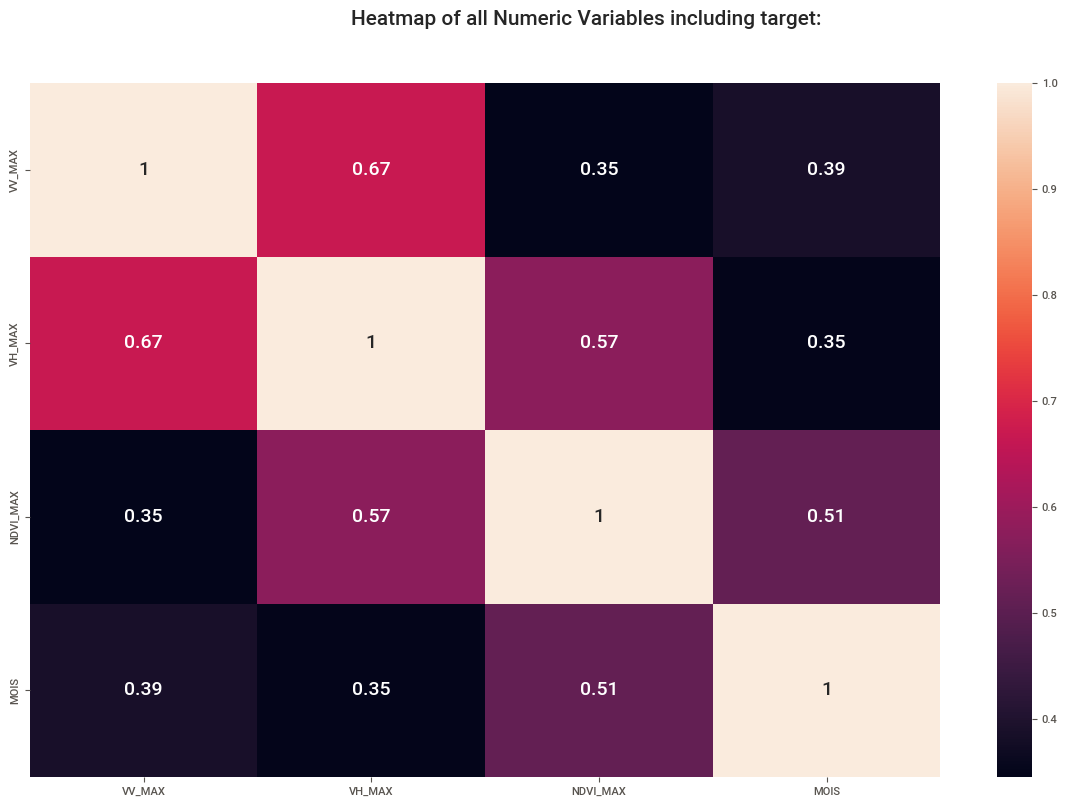

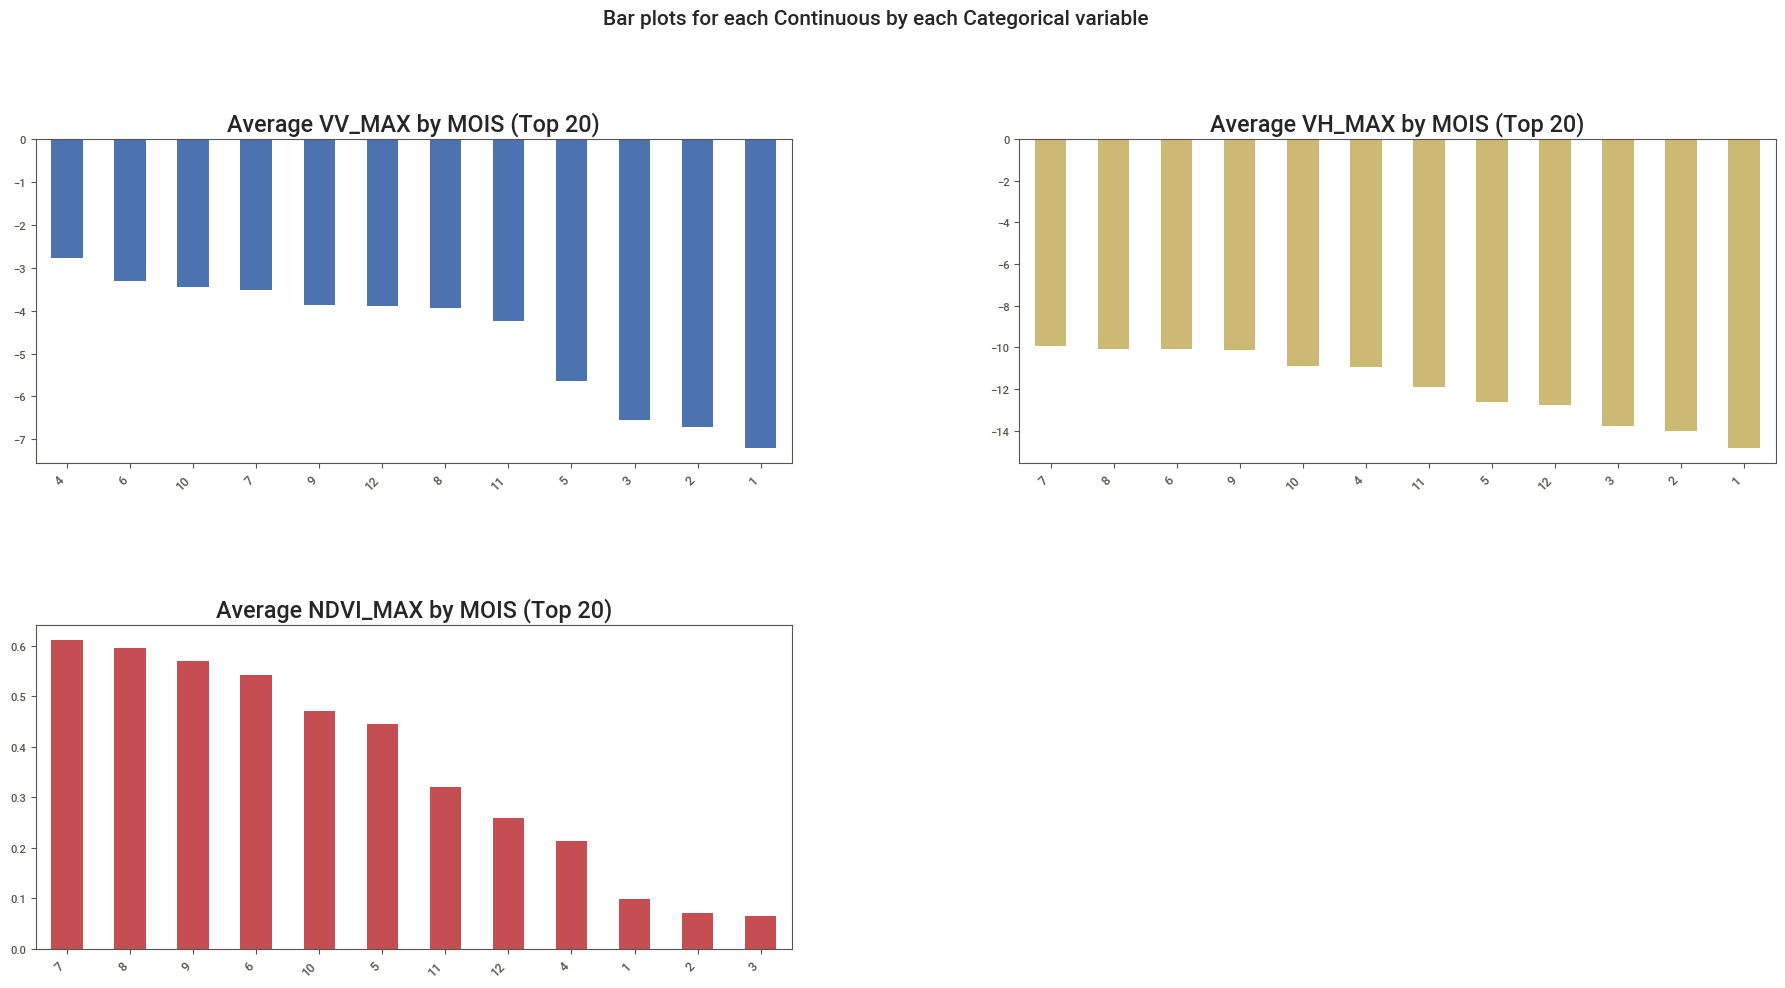

All Plots done
Time to run AutoViz = 5 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [381]:
AV = AutoViz_Class()
%matplotlib inline
_ = AV.AutoViz("",dfte=df)